In [1]:
# R version 4.1.0 #
# Load packages: Seurat_4.1.1, RColorBrewer_1.1-3, ggplot2_3.3.6, extrafont_0.18, 
# ggpubr_0.4.0, tidyr_1.2.0, purrr_0.3.4,stringr_1.4.0

packages = c('Seurat','RColorBrewer','ggplot2','extrafont','ggpubr','tidyr','dplyr','purrr','stringr')
for (p in packages){
    suppressPackageStartupMessages(eval(bquote(library(.(p)))))
}

bnum_table <- read.delim('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t')

get_gene_list <- function(name,seurat){
    bnums <- c()
    genes <- c()
    for (annotation_type in c('go','tf','sr')){
        data_name = str_replace("source_data/included/Ecoli_RENAME_index.txt","RENAME",annotation_type)
        data = readLines(data_name)
        for (line in data[grepl(name, data)]){
            bnum <- strsplit(line,'\t')[[1]][1]
            if (bnum %in% bnum_table[['bnum']]){
                gene <- bnum_table[bnum_table['bnum']==bnum,'gene']
                if (gene %in% rownames(seurat)){
                    bnums <- c(bnums,bnum)
                    genes <- c(genes,gene)
                }
            }
        }
    }
    return(genes)
}


In [2]:
seurat_ds40 = readRDS('source_data/from_GEO/ds_seurat_PCA_UMAP_clusters_ds38_min10_v4.rds') # download from GEO; or saved in seurat_ds38_min10_v4.R
seurat_full = readRDS('source_data/generated/seurat_full.rds') # run save_seurat_objects.R
counts <- GetAssayData(seurat_full, assay = "RNA")
counts <- counts[-(which(rownames(counts) %in% c('rRNA'))),]
seurat_full <- subset(seurat_full, features = rownames(counts))

hipA7_seurat = readRDS('source_data/generated/hip_only_seurat.rds') # hipA7_only.R
d6_seurat = readRDS('source_data/generated/day6_only_seurat.rds') # 6day_only.R
d6_d1_metG_seurat = readRDS('source_data/generated/day6_and_metG_seurat.rds') # 6day_metG_only.R
seurat_ds30 = readRDS('source_data/generated/ds30_seurat_PCA_UMAP_clusters.rds') # ds30_seurat.R


In [3]:
to_include = c('t1_2hr_WT_20210722','t1_20min_WT_20210722','t1_undil_WT_20210722',
               't2_20min_WT_20210722','t2_undil_WT_20210722','t3_undil_WT_20210722',
               't4_2hr_WT_20210722','t4_1hr_WT_20210722','t4_20min_WT_20210722','t4_undil_WT_20210722',
               't1_2hr_metG_20210623','t1_20min_metG_20210623','t1_undil_metG_20210623',
               't2_2hr_metG_20210623','t2_20min_metG_20210623','t2_undil_metG_20210623','t3_undil_metG_20210623',
               't4_2hr_metG_20210623','t4_20min_metG_20210623','t4_undil_metG_20210623',
               'WT_1hr_20220331','WT_30min_20220331','WT_10min_20220331','WT_3min_20220331','WT_stat_20220331',
               'metG6_20201018_1','metG5_20201018_1','metG4_20201018_1','metG3_20201018_1','metG2_20200926','metG1_20200926',
               'd6_1hr_1_20220422','d6_1hr_2_20220422','d1_1hr_1_20220807','d6_amp_3_20220422',
               'h1_42min_20211217','h2_42min_20211217','h3_50min_20211217','metG_52min_20211217',
               'tet1_20211014','tet5_20211014','WT_1hr_20220527','WT_42min_20211217','tet2_20211014',
               'wt_amp_20231016','wt_1hr_20231016','tet1hr_20230919','metG_pre_20231016','metG_amp_20231016'
              )
seurat_ds40@active.ident <- seurat_ds40$cell.type
seurat_ds40 <- subset(seurat_ds40,idents=to_include)

seurat_ds30@active.ident <- seurat_ds30$cell.type
seurat_ds30 <- subset(seurat_ds30,idents=to_include)


In [4]:
plot_pc1 <- function(sub_seurat,cols,pc='PC_1',xmin,xmax,slot=sub_seurat$seurat_clusters) {
    umap_df <- data.frame(umap = sub_seurat$pca@cell.embeddings[,pc],type=slot)
    umap_df2 <- umap_df %>%
      nest(-type) %>%
      mutate(density = map(data, ~density(.x$umap))) %>%
      mutate(density.x = map(density, ~.x[["x"]]),
             density.y = map(density, ~.x[["y"]])) %>%
      select(type, density.x, density.y) %>%
      unnest()
    options(repr.plot.width=4.2358, repr.plot.height=1.2)
    p <- ggplot(umap_df2,aes(x = density.x, y = density.y, color = type)) + geom_line(size=1)+theme_classic()+
    scale_color_manual(labels = levels(slot),values = cols,name='') + 
    scale_fill_manual(labels = levels(slot),values = alpha(cols,1),name='') +
    xlim(xmin,xmax) +  #geom_hline(yintercept=0, colour="white", size=3) +
    theme(text=element_text(family= "Arial", size=12)) + 
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank(),  #remove y axis ticks
        legend.position = "none",
        axis.title.x=element_blank(),
        axis.title.y=element_blank()) 
    return(p)
}

plot_pc2 <- function(sub_seurat,cols,pc='PC_2',xmin,xmax,slot=sub_seurat$seurat_clusters) {
    umap_df <- data.frame(umap = sub_seurat$pca@cell.embeddings[,pc],type=slot)
    umap_df2 <- umap_df %>%
      nest(-type) %>%
      mutate(density = map(data, ~density(.x$umap))) %>%
      mutate(density.x = map(density, ~.x[["x"]]),
             density.y = map(density, ~.x[["y"]])) %>%
      select(type, density.x, density.y) %>%
      unnest()
    options(repr.plot.height=4.2358, repr.plot.width=1.2)
    p <- ggplot(umap_df2,aes(x = density.x, y = density.y, color = type)) + geom_line(size=1)+theme_classic()+
    scale_color_manual(labels = levels(slot),values = cols,name='') + 
    scale_fill_manual(labels = levels(slot),values = alpha(cols,1),name='') +
    xlim(xmin,xmax) +  #geom_hline(yintercept=0, colour="white", size=3) +
    theme(text=element_text(family= "Arial", size=12)) + 
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.x=element_blank(),  #remove y axis ticks
        legend.position = "none",
        axis.title.x=element_blank(),
        axis.title.y=element_blank()) + coord_flip()
    return(p)
}


An object of class Seurat 
5395 features across 18282 samples within 1 assay 
Active assay: RNA (5395 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_line()`).”


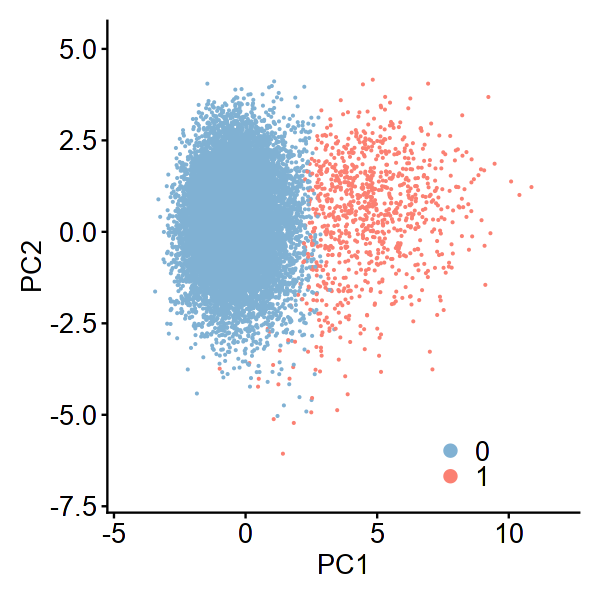

Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_line()`).”


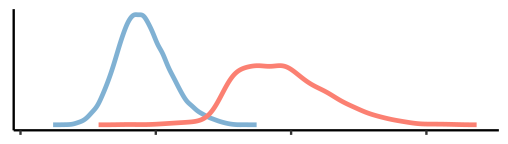

In [5]:
# fig a
sub_seurat <- hipA7_seurat
sub_seurat$pca@cell.embeddings[,'PC_1'] = -sub_seurat$pca@cell.embeddings[,'PC_1'] ## flip PC1
sub_seurat$pca@feature.loadings[,'PC_1'] = -sub_seurat$pca@feature.loadings[,'PC_1'] ## flip PC1
sub_seurat
options(repr.plot.width=5, repr.plot.height=5)
my_cols = brewer.pal(8,"Set3")
alpha = 1
pt.size = 0.1
xmin = min(sub_seurat$pca@cell.embeddings[,'PC_1'])-1
xmax = max(sub_seurat$pca@cell.embeddings[,'PC_1'])+1
ymin = min(sub_seurat$pca@cell.embeddings[,'PC_2'])-1
ymax = max(sub_seurat$pca@cell.embeddings[,'PC_2'])+1

sub_seurat$cell.type <- droplevels(sub_seurat$cell.type)
DimPlot(sub_seurat,pt.size=pt.size,reduction='pca') +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c("0", "1"), values = alpha(my_cols[c(5,4)],alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),legend.text=element_text(size=16),legend.position=c(0.7,0.1))
ggsave('figures/figED5a.pdf',width = 5, height = 5)

cols = my_cols[c(5,4)]
plot_pc1(sub_seurat,cols,'PC_1',xmin,xmax,sub_seurat$seurat_clusters)
ggsave('figures/figED5a_top.pdf',width = 4.2358,height = 1.2)


As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.


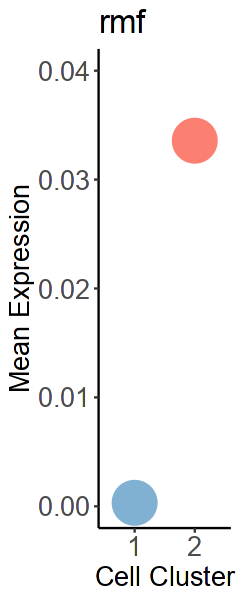

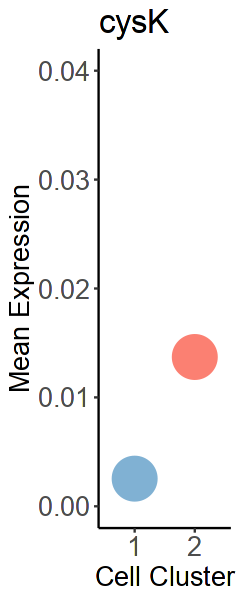

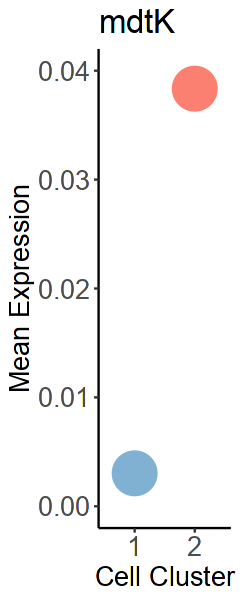

In [6]:
# fig B

seurat <- hipA7_seurat

options(repr.plot.width=2, repr.plot.height=5)
seurat@active.ident <- seurat$seurat_clusters

terms <- c('rmf','cysK','mdtK')
for (term in terms){
    marker_list <- c(term)
    term_avg <- colMeans(AverageExpression(seurat,slot='data',features=marker_list)$RNA)
    df <- data.frame(rev(term_avg))
    df['cluster'] = c('1','2')
    df['border'] = c('1','2')
    fill_colors = my_cols[c(5,4)]
    labels = c("1","2")
    border_colors = fill_colors
    p <- ggplot(data=df, aes(x=cluster, y=term_avg,group=1,fill=border,color=border)) +
        geom_point(size=8,shape=21,stroke=3) + theme_classic() + scale_fill_manual(values=fill_colors,name='',labels=labels) + 
        scale_color_manual(values=border_colors,name='',labels=labels) + 
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_text(family= "Arial", size=16)) + 
        xlab('Cell Cluster') + ylab('Mean Expression') + ylim(0,0.04) + ggtitle(term)
    filename = paste('figures/figED5B_expression_',str_replace(str_split(term,' ',simplify=TRUE)[1],':','_'),'.pdf',sep='')
    print(p)
    ggsave(filename,width=2,height=5)
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


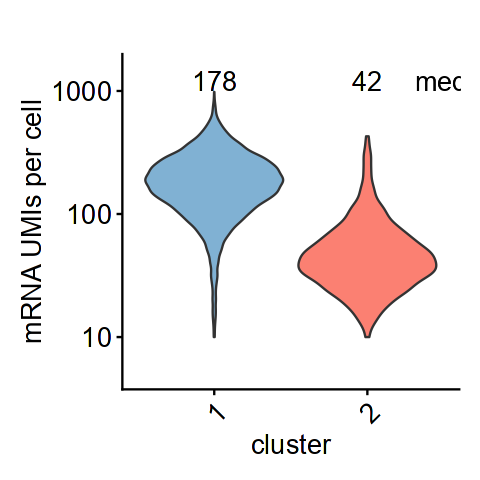

In [7]:
# fig C

options(repr.plot.width=4, repr.plot.height=4)

hipA7_seurat@active.ident <- hipA7_seurat$cell.type
ids = levels(hipA7_seurat$cell.type)
cells = subset(hipA7_seurat,idents=ids)$seurat_clusters ## get cell names by hipA7 cluster
seurat <- subset(seurat_full,cells=names(cells))
seurat@active.ident <- hipA7_seurat$seurat_clusters # group full seurat object (before downsample) by hipA7 clusters

my_cols = brewer.pal(8,"Set3")

p <- VlnPlot(seurat, features = c("nCount_RNA"),ncol = 1, log=FALSE,pt.size=0) + 
    theme(legend.position = "none") + 
    scale_y_log10(limits = c(5,1500))

x <- 1
for (ident in levels(seurat@active.ident)){
    med <- median(subset(seurat, idents=c(ident))$nCount_RNA)
    p <- p + annotate("text",x=x, y=1200, label=med, size=16 / .pt, family="Arial")
    x <- x+1
}
p <- p + scale_fill_manual(labels=c("1","2"),values=alpha(my_cols[c(5,4)],1))
p <- p + annotate("text",x=2.6, y=1200, label='median', size=16 / .pt, family="Arial")
p <- p + scale_x_discrete(breaks=levels(seurat@active.ident),labels=c("1","2"))
p <- p + theme(text=element_text(family= "Arial", size=16),axis.text = element_text(family= "Arial", size=16,angle = 0,hjust=0.5))
p <- p + ylab("mRNA UMIs per cell") + xlab('') + ggtitle('') + xlab('cluster')
p
ggsave('figures/figED5C.pdf',width = 4, height = 6)



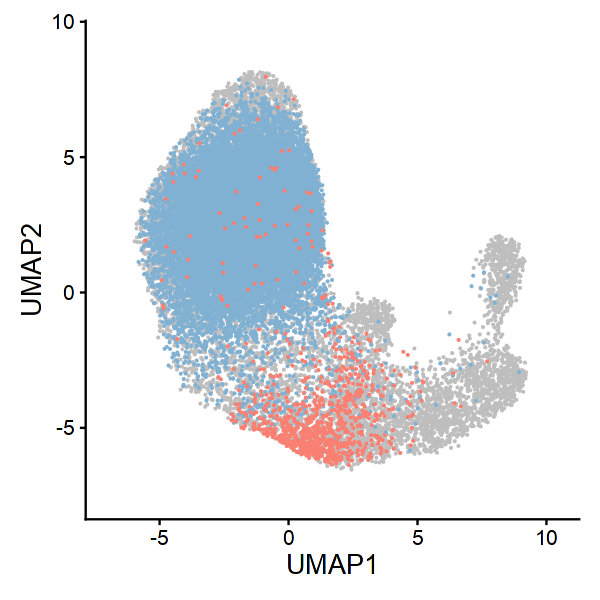

In [8]:
seurat <- seurat_ds40
hipA7_seurat@active.ident <- hipA7_seurat$seurat_clusters

levels(seurat$seurat_clusters) = c(levels(seurat$seurat_clusters),'10')
seurat$seurat_clusters[!names(seurat$seurat_clusters) %in% names(hipA7_seurat$seurat_clusters)] = '10'
seurat$seurat_clusters[names(seurat$seurat_clusters) %in% names(subset(hipA7_seurat,idents=0)$seurat_clusters)] = '0'
seurat$seurat_clusters[names(seurat$seurat_clusters) %in% names(subset(hipA7_seurat,idents=1)$seurat_clusters)] = '1'

options(repr.plot.width=5, repr.plot.height=5)
alpha = 1
pt.size = 0.1
xmin = min(seurat$umap@cell.embeddings[,'UMAP_1'])-1
xmax = max(seurat$umap@cell.embeddings[,'UMAP_1'])+1
ymin = min(seurat$umap@cell.embeddings[,'UMAP_2'])-1
ymax = max(seurat$umap@cell.embeddings[,'UMAP_2'])+1
seurat$seurat_clusters <- droplevels(seurat$seurat_clusters)

seurat@active.ident <- seurat$seurat_clusters
sampled.cells <- names(hipA7_seurat$seurat_clusters)
sampled.cells <- c(sampled.cells,sample(x = names(subset(seurat,idents='10')$cell.type),size=10000,replace=FALSE))

alpha = c(0.1,1,1)
DimPlot(subset(seurat,cells=sampled.cells),pt.size=pt.size,order=rev(c('0','1'))) +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c('',"0","1"), values = alpha(c('gray',my_cols[c(5,4)]),alpha))+ xlab('UMAP1') + ylab('UMAP2') +
    theme(text=element_text(family= "Arial", size=16),legend.position='none',legend.title = element_text(face = "bold"))
ggsave('figures/figED5D.pdf',width = 5, height = 5)


An object of class Seurat 
5395 features across 25120 samples within 1 assay 
Active assay: RNA (5395 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

[1] 0.0003184713 0.0022292994 0.0738455414 0.0167197452 0.2217356688
[6] 0.6649283439 0.0202229299

[1] "0" "1" "2" "3" "4" "5" "6"


Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Removed 23 rows containing missing values or values outside the scale range (`geom_line()`).”


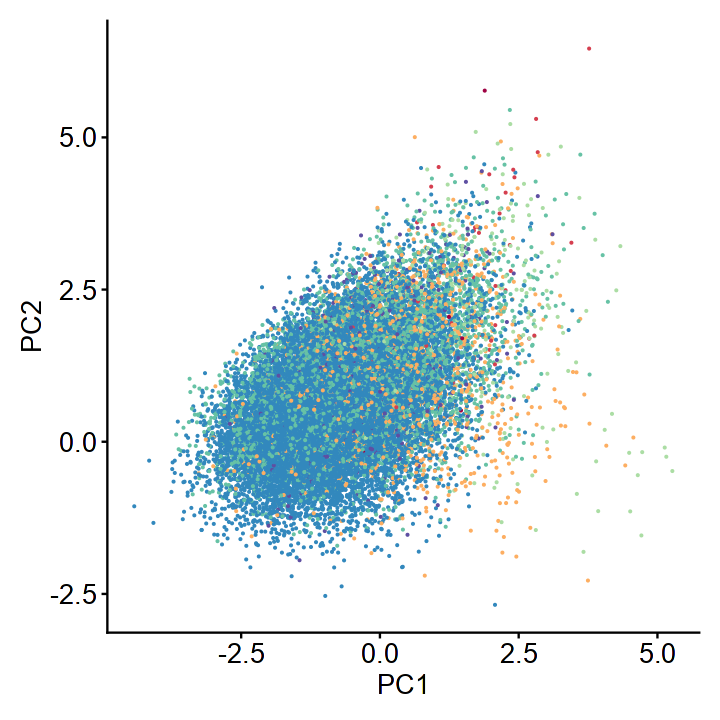

Warning message:
“Removed 23 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Removed 35 rows containing missing values or values outside the scale range (`geom_line()`).”


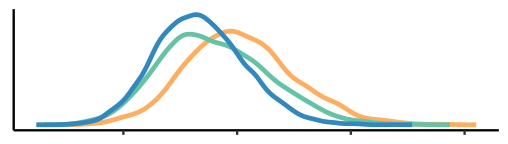

Warning message:
“Removed 35 rows containing missing values or values outside the scale range (`geom_line()`).”


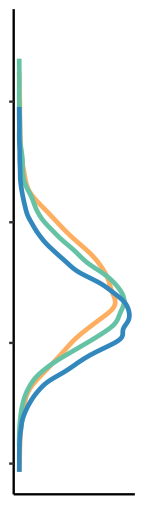

In [9]:
# fig E
d6_seurat$clusters <- subset(seurat_ds40,cells=names(d6_seurat$cell.type))$seurat_clusters
d6_seurat@active.ident <- d6_seurat$clusters
d6_seurat
prop.table(as.integer(table(d6_seurat$clusters)))
options(repr.plot.width=5, repr.plot.height=5)

sub_seurat <- d6_seurat
sub_seurat@active.ident <- sub_seurat$clusters
options(repr.plot.width=6, repr.plot.height=6)
my_cols = brewer.pal(10,"Spectral")
alpha = 1
pt.size = 0.1
xmin = min(sub_seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(sub_seurat$pca@cell.embeddings[,'PC_1'])
ymin = min(sub_seurat$pca@cell.embeddings[,'PC_2'])
ymax = max(sub_seurat$pca@cell.embeddings[,'PC_2'])

ids = levels(sub_seurat$clusters)
print(ids)

DimPlot(sub_seurat,pt.size=pt.size,reduction='pca',shuffle=TRUE) +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(name='Cell Clusters',labels = c("Early Stationary", "Stationary","Persister","Early Lag","Late Lag","Early Exponential","Late Exponential"), values = alpha(my_cols[c(1,2,4,7,8,9,10)],alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(size=16),legend.position='none')
ggsave('figures/figED5e.pdf',width = 5, height = 5)


my_cols = brewer.pal(10,"Spectral")
cols = my_cols[c(4,8,9)]
sub_seurat <- subset(d6_seurat,idents=c('2','4','5'))
sub_seurat$clusters <- droplevels(sub_seurat$clusters)
plot_pc1(sub_seurat,cols,'PC_1',xmin,xmax,sub_seurat$clusters)
ggsave('figures/figED5e_top.pdf',width = 4.2358,height = 1.2)
plot_pc2(sub_seurat,cols,'PC_2',ymin,ymax,sub_seurat$clusters)
ggsave('figures/figED5e_right.pdf',height = 4.2358,width = 1.2)


Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Removed 55 rows containing missing values or values outside the scale range (`geom_line()`).”


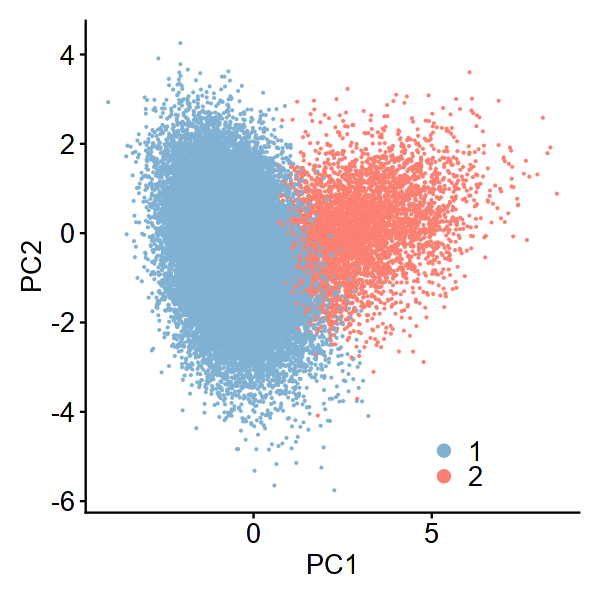

Warning message:
“Removed 55 rows containing missing values or values outside the scale range (`geom_line()`).”


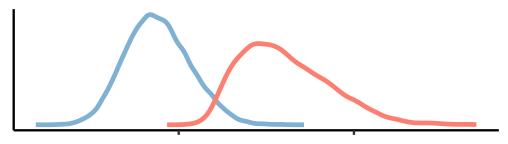

In [10]:
# fig F

## add 6-day/1-day/metG* as cell group classifications
cells = names(d6_d1_metG_seurat$cell.type)[grepl('d6',d6_d1_metG_seurat$cell.type)]
d6_d1_metG_seurat$cell.type.group <- d6_d1_metG_seurat$cell.type
levels(d6_d1_metG_seurat$cell.type.group) = c(levels(d6_d1_metG_seurat$cell.type.group),'d6')
d6_d1_metG_seurat$cell.type.group[cells] = 'd6'

## plot PCA
sub_seurat <- d6_d1_metG_seurat
sub_seurat@active.ident <- sub_seurat$seurat_clusters
options(repr.plot.width=5, repr.plot.height=5)
my_cols = brewer.pal(8,"Set3")
alpha = 1
pt.size = 0.1
xmin = min(sub_seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(sub_seurat$pca@cell.embeddings[,'PC_1'])
ymin = min(sub_seurat$pca@cell.embeddings[,'PC_2'])
ymax = max(sub_seurat$pca@cell.embeddings[,'PC_2'])

DimPlot(sub_seurat,pt.size=pt.size,reduction='pca') +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c("1", "2"), values = alpha(my_cols[c(5,4)],alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),legend.text=element_text(size=16),legend.position=c(0.7,0.1))
ggsave('figures/figED5F.pdf',width = 5, height = 5)


cols = my_cols[c(5,4)]
plot_pc1(sub_seurat,cols,'PC_1',xmin,xmax,sub_seurat$seurat_clusters)
ggsave('figures/figED5F_top.pdf',width = 4.2358,height = 1.2)

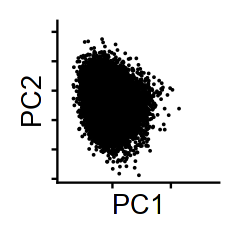

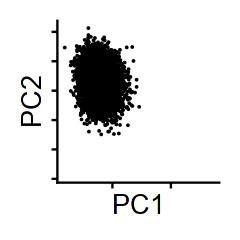

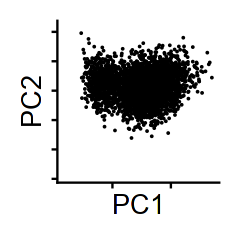

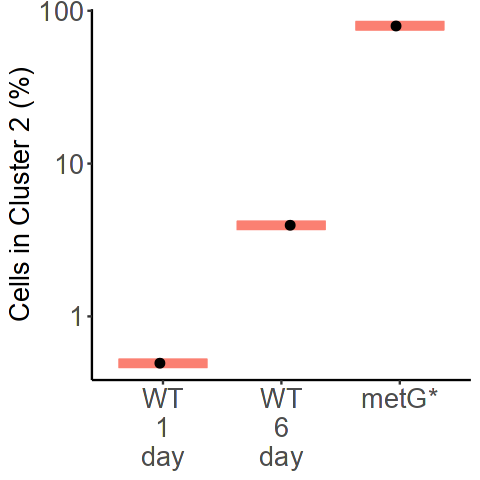

In [11]:
# fig G

d6_d1_metG_seurat@active.ident <- d6_d1_metG_seurat$cell.type.group
sub_seurat <- d6_d1_metG_seurat
xmin = min(sub_seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(sub_seurat$pca@cell.embeddings[,'PC_1'])
ymin = min(sub_seurat$pca@cell.embeddings[,'PC_2'])
ymax = max(sub_seurat$pca@cell.embeddings[,'PC_2'])

options(repr.plot.width=2, repr.plot.height=2)
alpha = 0.1
pt.size = 0.01

sub_seurat <- subset(d6_d1_metG_seurat,idents='d6')
DimPlot(sub_seurat,pt.size=pt.size,reduction='pca') +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c(""), values = alpha('black',alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),legend.text=element_text(size=16),legend.position='none') +
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank())  #remove y axis labels
ggsave('figures/figED5G_middle.pdf',width = 1.7, height = 1.7)

sub_seurat <- subset(d6_d1_metG_seurat,idents='d1_1hr_1_20220807')
DimPlot(sub_seurat,pt.size=pt.size,reduction='pca') +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c(""), values = alpha('black',alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),legend.text=element_text(size=16),legend.position='none') +
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank())  #remove y axis labels
ggsave('figures/figED5G_left.pdf',width = 1.7, height = 1.7)

sub_seurat <- subset(d6_d1_metG_seurat,idents='metG1_20200926')
DimPlot(sub_seurat,pt.size=pt.size,reduction='pca') +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(labels = c(""), values = alpha('black',alpha))+ xlab('PC1') + ylab('PC2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),legend.text=element_text(size=16),legend.position='none') +
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank())  #remove y axis labels
ggsave('figures/figED5G_right.pdf',width = 1.7, height = 1.7)


# bottom part

seurat <- d6_d1_metG_seurat
seurat@active.ident <- seurat$cell.type.group
ids = c('d6')
d6_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[2]
  d6_list = c(d6_list,prop)
}

ids = c('d1_1hr_1_20220807')
d1_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[2]
  d1_list = c(d1_list,prop)
}

ids = c('metG1_20200926')
metG_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[2]
  metG_list = c(metG_list,prop)
}

fraction = c(d1_list, d6_list,metG_list)
type = rep(c("1-day WT","6-day WT","metG*"), c(length(d1_list),length(d6_list),length(metG_list)))

l = c("WT\n1\nday","WT\n6\nday","metG*")
type = factor(rep(l,c(length(d1_list),length(d6_list),length(metG_list))),levels=l)

DATASET <- data.frame(fraction,type,stringsAsFactors = TRUE)

options(repr.plot.width=4, repr.plot.height=4)

set.seed(1)
my_comparisons <- list(l)
DATASET$type <- factor(DATASET$type,levels=l)
ggplot(DATASET, aes(type, 100*fraction)) +
    geom_boxplot(colour = my_cols[4],lwd=2,fatten=1) + 
    geom_jitter(colour = 'black',size=2,width=0.1,height=0) + theme_classic()  + 
    scale_y_log10() + ylab('Cells in Cluster 2 (%)') + 
    theme(axis.line.y.right = element_blank(), axis.text.y.right = element_blank(), axis.ticks.y.right = element_blank(), axis.title.y.right = element_blank()) + 
    theme(
        axis.title.x = element_blank(),
        text=element_text(family= "Arial", size=16),
        axis.text.y = element_text(family= "Arial", size=16),
        axis.text.x = element_text(family= "Arial", size=16),
        axis.title.y = element_text(family= "Arial", size=16),
        legend.position='none')
ggsave('figures/figED5G_bottom.pdf',width = 4, height = 4)



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


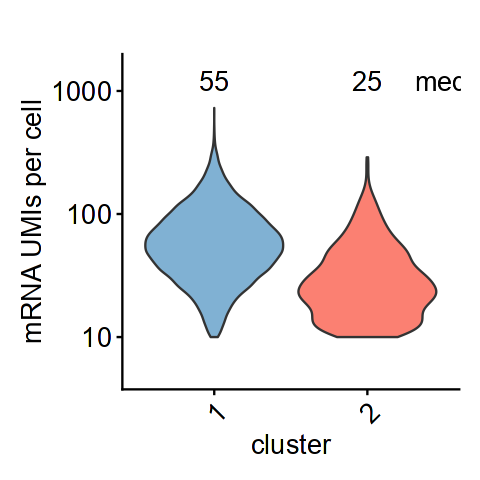

In [12]:
# fig H
d6_d1_metG_seurat@active.ident <- d6_d1_metG_seurat$cell.type
ids = c('d6_1hr_1_20220422','d6_1hr_2_20220422')
cells = subset(d6_d1_metG_seurat,idents=ids)$seurat_clusters
cells = names(cells)
seurat <- subset(seurat_full,cells=cells)
seurat@active.ident <- d6_d1_metG_seurat$seurat_clusters
my_cols = brewer.pal(8,"Set3")

p <- VlnPlot(seurat, features = c("nCount_RNA"),ncol = 1, log=FALSE,pt.size=0) + 
    theme(legend.position = "none") + 
    scale_y_log10(limits = c(5,1500))

x <- 1
for (ident in levels(seurat@active.ident)){
    med <- median(subset(seurat, idents=c(ident))$nCount_RNA)
    p <- p + annotate("text",x=x, y=1200, label=med, size=16 / .pt, family="Arial")
    x <- x+1
}
p <- p + scale_fill_manual(labels=c("1","2"),values=alpha(my_cols[c(5,4)],1))
p <- p + annotate("text",x=2.6, y=1200, label='median', size=16 / .pt, family="Arial")
p <- p + scale_x_discrete(breaks=levels(seurat@active.ident),labels=c("1","2"))
p <- p + theme(text=element_text(family= "Arial", size=16),axis.text = element_text(family= "Arial", size=16,angle = 0,hjust=0.5))
p <- p + ylab("mRNA UMIs per cell") + xlab('') + ggtitle('') + xlab('cluster')
p
ggsave('figures/figED5H.pdf',width = 4, height = 6)


[1] "0" "1" "2" "3" "4" "5" "6"


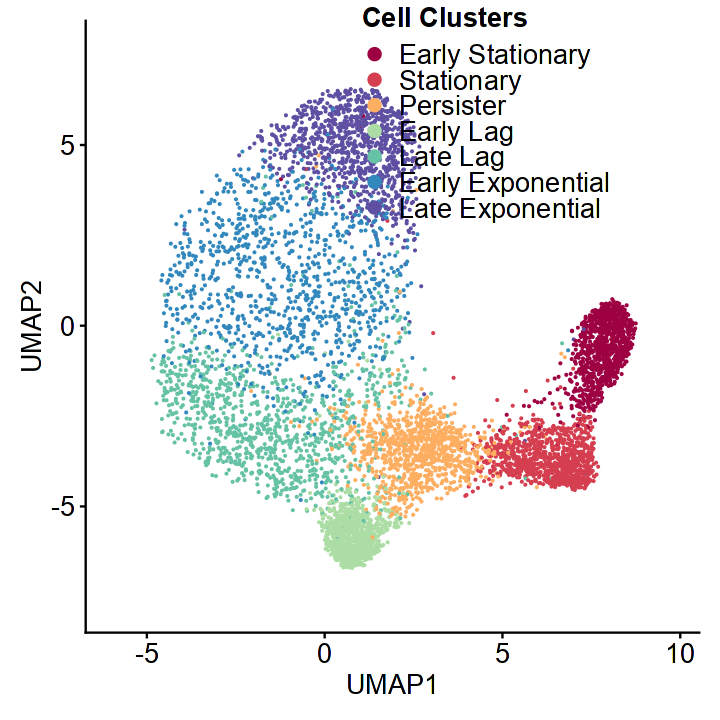

In [13]:
seurat <- seurat_ds30

seurat@active.ident <- seurat$seurat_clusters
options(repr.plot.width=6, repr.plot.height=6)
my_cols = brewer.pal(10,"Spectral")
n_cells_per = 1000
alpha = 1
pt.size = 0.1
xmin = min(seurat$umap@cell.embeddings[,'UMAP_1'])-1
xmax = max(seurat$umap@cell.embeddings[,'UMAP_1'])+1
ymin = min(seurat$umap@cell.embeddings[,'UMAP_2'])-1
ymax = max(seurat$umap@cell.embeddings[,'UMAP_2'])+1

ids = levels(seurat$seurat_clusters)
print(ids)

sub_seurat=subset(seurat,idents=ids)
sampled.cells <- c()
set.seed(111)
for(id in levels(sub_seurat$seurat_clusters)){
    sampled.cells <- c(sampled.cells,sample(x = names(subset(sub_seurat,idents=id)$cell.type), size = n_cells_per, replace = F))
}

DimPlot(subset(sub_seurat,cells=sampled.cells),pt.size=pt.size) +
    xlim(xmin,xmax) + ylim(ymin,ymax) +
    scale_color_manual(name='Cell Clusters',labels = c("Early Stationary", "Stationary","Persister","Early Lag","Late Lag","Early Exponential","Late Exponential"), values = alpha(my_cols[c(1,2,4,7,8,9,10)],alpha))+ xlab('UMAP1') + ylab('UMAP2') +
    theme(text=element_text(family= "Arial", size=16),axis.text=element_text(size=16),legend.text=element_text(size=16),legend.position=c(0.45,0.85),legend.title = element_text(face = "bold"))
ggsave('figures/figED5I.pdf',width = 6, height = 6)



Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <97>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '∗' in 'mbcsToSbcs': dot substituted for <97>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label

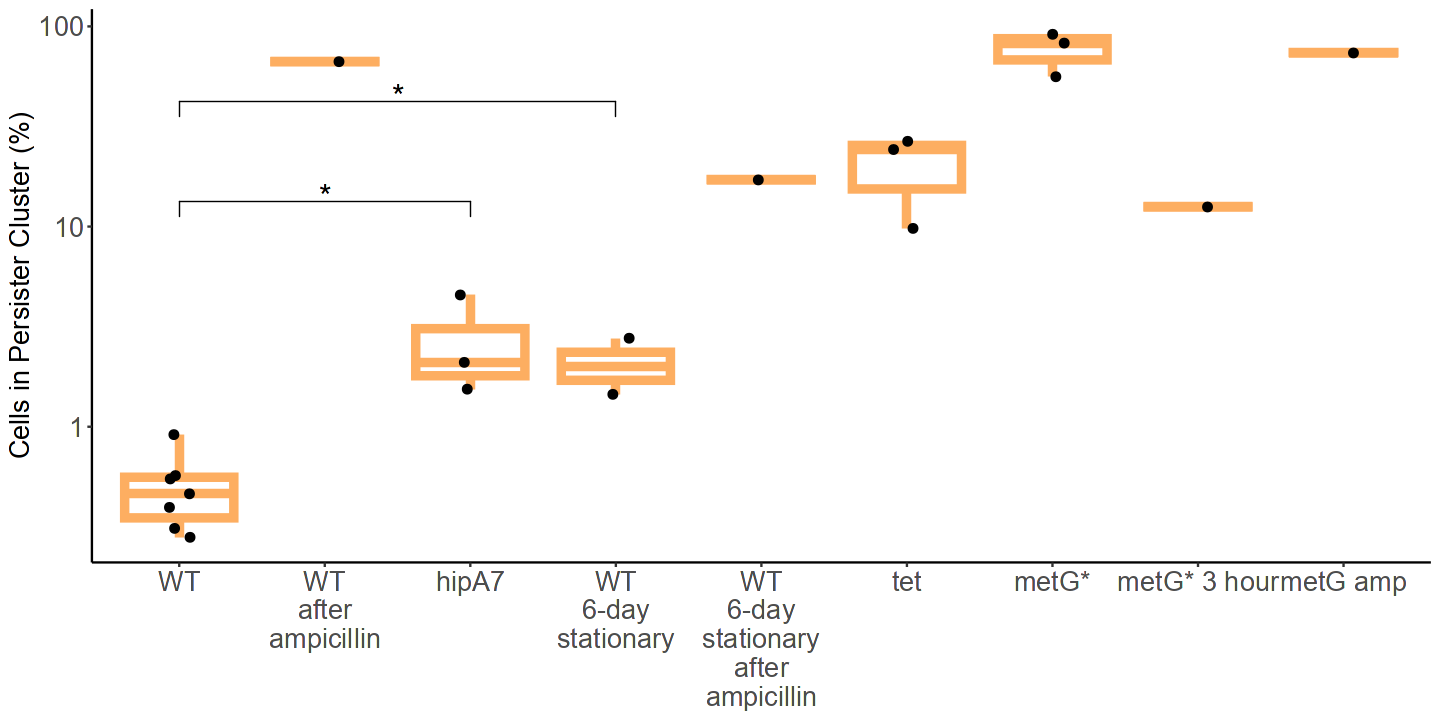

In [14]:
seurat <- seurat_ds30
seurat@active.ident <- seurat$cell.type

ids = c('t4_1hr_WT_20210722','WT_1hr_20220331','WT_42min_20211217','d1_1hr_1_20220807','WT_1hr_20220527','tet2_20211014','wt_1hr_20231016')
wt_list = c()
for (ident in ids){
  #print(ident)
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  #print(prop)
  wt_list = c(wt_list,prop)
}

ids = levels(seurat$cell.type)[(grepl('h1|h2|h3',levels(seurat$cell.type)))&(grepl('42min|50min',levels(seurat$cell.type)))]
hip_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  hip_list = c(hip_list,prop)
}

ids = c('d6_1hr_1_20220422','d6_1hr_2_20220422') 
#print(ids)
d6_list = c()
for (ident in ids){
  #print(ident)
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  #print(prop)
  d6_list = c(d6_list,prop)
}

ids = c('d6_amp_3_20220422')
#print(ids)
d6_amp_list = c()
for (ident in ids){
  #print(ident)
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  #print(prop)
  d6_amp_list = c(d6_amp_list,prop)
}

ids = c('wt_amp_20231016')
#print(ids)
wt_amp_list = c()
for (ident in ids){
  #print(ident)
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  #print(prop)
  wt_amp_list = c(wt_amp_list,prop)
}

ids = c('tet1_20211014','tet5_20211014','tet1hr_20230919')
tet_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  tet_list = c(tet_list,prop)
}

ids = c('metG1_20200926','metG5_20201018_1','metG_52min_20211217')
metG_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  metG_list = c(metG_list,prop)
}

ids = c('metG_pre_20231016')
metGpre_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  metGpre_list = c(metGpre_list,prop)
}

ids = c('metG_amp_20231016')
metGamp_list = c()
for (ident in ids){
  prop = prop.table(as.integer(table(subset(seurat,idents=ident)$seurat_clusters)))[3]
  metGamp_list = c(metGamp_list,prop)
}

fraction = c(wt_list, wt_amp_list,hip_list,d6_list,d6_amp_list,tet_list,metG_list,metGpre_list,metGamp_list)
l = c("WT","WT\nafter\nampicillin","hipA7","WT\n6-day\nstationary","WT\n6-day\nstationary\nafter\nampicillin","tet","metG*","metG* 3 hour","metG amp")
type = rep(l, c(length(wt_list),length(wt_amp_list),length(hip_list),length(d6_list),length(d6_amp_list),length(tet_list),length(metG_list),length(metGpre_list),length(metGamp_list)))
DATASET <- data.frame(fraction,type,stringsAsFactors = TRUE)


options(repr.plot.width=12, repr.plot.height=6)
set.seed(1)
DATASET$type <- factor(DATASET$type,levels=l)
my_comparisons <- list( l[c(1,3)],l[c(1,4)] )

ggplot(DATASET, aes(type, 100*fraction)) +
    geom_boxplot(colour = my_cols[4],lwd=2,fatten=1) +
    geom_jitter(colour = 'black',size=2,width=0.1,height=0) + theme_classic()  + scale_y_log10() +
    theme(
        axis.title.x = element_blank(),
        text=element_text(family= "Arial", size=16),
        axis.text.y = element_text(family= "Arial", size=16),
        axis.text.x = element_text(family= "Arial", size=16),
        axis.title.y = element_text(family= "Arial", size=16),
        legend.position='none') + ylab('Cells in Persister Cluster (%)') + 
    stat_compare_means(comparisons = my_comparisons, label='p.signif',
                       symnum.args=list(
                       cutpoints = c(0, 0.0005, 0.005, 0.05, 1), 
                       symbols = c("\u2217\u2217\u2217", "\u2217\u2217", "\u2217", "ns"),
                       family='mono'),
                        label.x = 1.5, label.y = c(1,1.5), size=6,method.args = list(alternative = "less"),method = "wilcox")


ggsave('figures/figED5J.pdf',width = 6, height = 6)



Warning message in mean.default(AverageExpression(subset(seurat, cells = cells), :
“argument is not numeric or logical: returning NA”
Warning message in mean.default(AverageExpression(subset(seurat, cells = cells), :
“argument is not numeric or logical: returning NA”
Warning message in mean.default(AverageExpression(subset(seurat, cells = cells), :
“argument is not numeric or logical: returning NA”
Warning message in mean.default(AverageExpression(subset(seurat, cells = cells), :
“argument is not numeric or logical: returning NA”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning 

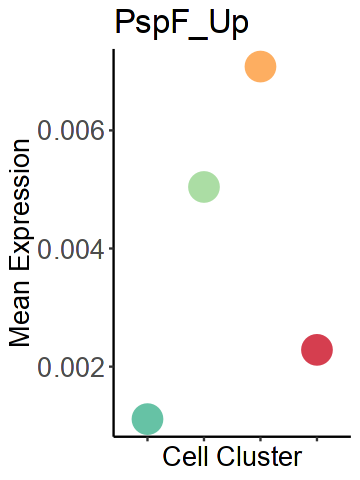

Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message in mean.default(AverageExpression(subset(seurat, cells = cells), :
“argu

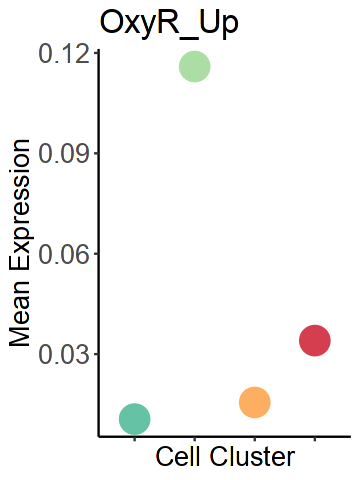

Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_segment()`).”


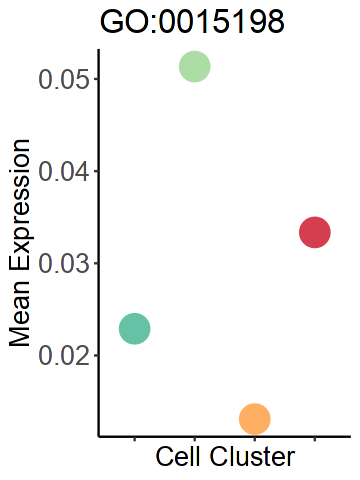

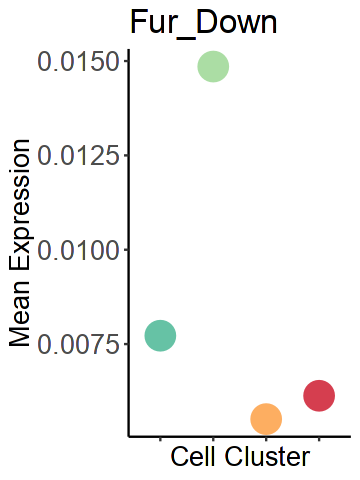

In [15]:
selected_terms <- c('PspF_Up','OxyR_Up','GO:0015198','Fur_Down')

options(repr.plot.width=3, repr.plot.height=4)
seurat <- seurat_ds40
seurat@active.ident <- seurat$seurat_clusters
seurat_clust2 <- subset(seurat,idents=c(2))
seurat_clust2@active.ident <- seurat$cell.type
slot = 'data'
for (term in selected_terms){
    my_cols = brewer.pal(10,"Spectral")
    marker_list <- get_gene_list(str_split(term,' ',simplify=TRUE)[1],seurat) ## all bnums in term
    marker_list <- unique(marker_list)
    term_avg <- colMeans(AverageExpression(seurat,slot='data',features=marker_list)$RNA)
    df <- data.frame(term_avg[2:5])
    df['cluster'] = rev(c('1','2','3','4'))
    df['border'] = rev(c('1','2','3','4'))
    fill_colors = rev(my_cols[c(2,4,7,8)])
    labels = rev(c("Stationary","Persister","Early Lag","Late Lag"))
    border_colors = fill_colors
    colnames(df) = c('avg','cluster','border')
    p <- ggplot(data=df, aes(x=cluster, y=avg,group=1,fill=border,color=border)) + 
        geom_point(size=4,shape=21,stroke=3) + theme_classic() + scale_fill_manual(values=fill_colors,name='',labels=labels) + 
        scale_color_manual(values=border_colors,name='',labels=labels) + 
        theme(text=element_text(family= "Arial", size=16),legend.position='none',
            axis.text.y = element_text(family= "Arial", size=16),
            axis.text.x = element_blank()) + 
        xlab('Cell Cluster') + ylab('Mean Expression') + ggtitle(term)
    my_cols = brewer.pal(8,"Set1")
    y <- unname(term_avg['2'])
    cells <- names(subset(seurat_clust2,idents=c('tet1_20211014','tet5_20211014','tet1hr_20230919'))$cell.type)
    m1 <- suppressMessages(mean(AverageExpression(subset(seurat,cells=cells),slot=slot,features=marker_list)$RNA))
    cells <- names(subset(seurat_clust2,idents=c('d6_1hr_1_20220422','d6_1hr_2_20220422'))$cell.type)
    m2 <- suppressMessages(mean(AverageExpression(subset(seurat,cells=cells),slot=slot,features=marker_list)$RNA))
    cells <- names(subset(seurat_clust2,idents=c('h1_42min_20211217','h2_42min_20211217','h3_50min_20211217'))$cell.type)
    m3 <- suppressMessages(mean(AverageExpression(subset(seurat,cells=cells),slot=slot,features=marker_list)$RNA))
    ids = c('metG_52min_20211217','metG1_20200926','metG2_20200926','metG5_20201018_1','metG6_20201018_1','t4_2hr_metG_20210623','metG_pre_20231016')
    cells <- names(subset(seurat_clust2,idents=c(ids))$cell.type)
    m4 <- suppressMessages(mean(AverageExpression(subset(seurat,cells=cells),slot=slot,features=marker_list)$RNA))
    p <- p + geom_segment(aes(x = 3-0.3, y = y, xend = 3-0.3, yend = m1),colour='black',
                      arrow = arrow(length = unit(0.2, "cm"))) + 
        geom_segment(aes(x = 3-0.1, y = y, xend = 3-0.1, yend = m2),colour='blue',
                      arrow = arrow(length = unit(0.2, "cm"))) + 
        geom_segment(aes(x = 3+0.1, y = y, xend = 3+0.1, yend = m3),colour=my_cols[3],
                      arrow = arrow(length = unit(0.2, "cm"))) + 
        geom_segment(aes(x = 3+0.3, y = y, xend = 3+0.3, yend = m4),colour=my_cols[1],
                      arrow = arrow(length = unit(0.2, "cm")))
    print(p)
    filename = paste('figures/figED5_',str_replace(str_split(term,' ',simplify=TRUE)[1],':','_'),'.pdf',sep='')
    ggsave(filename,width=3,height=4)
}